<a href="https://colab.research.google.com/github/pletalk/EMPV-RPI-AutoDriving/blob/master/05-DeepPiCar-NVIDIA-AutoLaneFollow-Colab/02-DeepPiCar_DataAugment_AutonomousDriving_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepPiCar - 데이타 강화 OpenCV기반 자동 수집 주행 데이타 기반의 딥러닝 학습 및 주행(Deep Learning Driving)
@2020-08-01/@pletalk

* 문서이력
    * 2020-08-01 코드 점검 및 수정
    * 2020-06-14 재검증(OK)
    * 2020-05-24 코드추가하기(이미지로딩, 추가, 학습등)
    * 2020-05-23 처음작성

* [참고자료]
    * [참조 소스코드(DeepPiCar)](https://github.com/dctian/DeepPiCar/blob/master/models/lane_navigation/code/end_to_end_lane_navigation.ipynb)
    * [DeepPiCar — Part 5: Autonomous Lane Navigation via Deep Learning](https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110)

<img src="https://miro.medium.com/max/1374/1*p8JiHcvH-wpSxcCzz2r1Sw.jpeg"/>

## [1] DeepPiCar Git코드 다운로드
* 기본 다운로드 디렉토리는 /content/DeepPiCar 디렉토리에 저장

In [1]:
! git clone https://github.com/dctian/DeepPiCar.git

Cloning into 'DeepPiCar'...
remote: Enumerating objects: 1027, done.
remote: Total 1027 (delta 0), reused 0 (delta 0), pack-reused 1027
Receiving objects: 100% (1027/1027), 141.14 MiB | 23.05 MiB/s, done.
Resolving deltas: 100% (320/320), done.


In [4]:
! pwd
%cd DeepPiCar

/content
/content/DeepPiCar


## [2] 라이브러리 로딩하기

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import logging
import math

import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
from imgaug import augmenters as img_aug
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

Using TensorFlow backend.


tf.__version__: 2.2.0
keras.__version__: 2.3.1


## [3] OpenCV기반 주행선탐지를 위한 이미지 가져오기
    * directory에 주행을 캡쳐한 이미지들이 있음
    * 로딩을 위한 코드 작성

### 1> 학습할 동영상의 프레임별 이미지 파일 로딩하기

In [5]:
# 데이타를 가져올 디렉토리 설정하기
# 확장자 *.png를 가지는 파일들을 확인할 것
# 파일명의 포맷 -> 이름_순서_각도.png
data_dir = '/content/DeepPiCar/models/lane_navigation/data/images'

### 2> 이미지저장 디렉토리에서 이미지파일 파일 읽어서 분류하기 (경로, 각도)

In [7]:
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4])  # 092 part of video01_143_092.png is the angle. 90 is go straight
        steering_angles.append(angle)

### 3> 파일경로와 각도 리스트 확인하기

In [8]:
image_paths[0:3]

['/content/DeepPiCar/models/lane_navigation/data/images/video01_011_062.png',
 '/content/DeepPiCar/models/lane_navigation/data/images/video01_204_077.png',
 '/content/DeepPiCar/models/lane_navigation/data/images/video01_049_065.png']

In [9]:
steering_angles[0:3]

[62, 77, 65]

In [10]:
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([1.0000, 1.0000, 8.0000, 4.0000, 5.0000, 11.0000, 6.0000, 7.0000,
        26.0000, 2.0000, 10.0000, 21.0000, 18.0000, 23.0000, 15.0000,
        21.0000, 12.0000, 10.0000, 2.0000, 5.0000, 2.0000, 1.0000, 3.0000,
        2.0000, 3.0000]),
 array([44.0000, 46.3600, 48.7200, 51.0800, 53.4400, 55.8000, 58.1600,
        60.5200, 62.8800, 65.2400, 67.6000, 69.9600, 72.3200, 74.6800,
        77.0400, 79.4000, 81.7600, 84.1200, 86.4800, 88.8400, 91.2000,
        93.5600, 95.9200, 98.2800, 100.6400, 103.0000]),
 <a list of 25 Patch objects>)

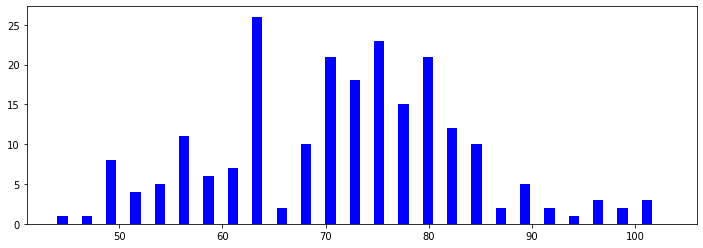

In [11]:
# 주행각도에 대한 분포
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

## [4] 학습데이타와 테스트 데이타 나누기

### 1> train_test_split()를 활용하여 나누기 (비율기반)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 175
Validation data: 44


Text(0.5, 1.0, 'Validation Data')

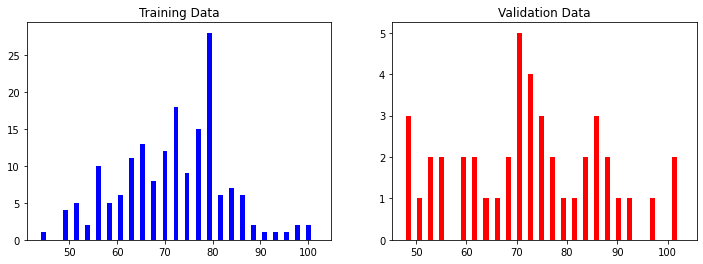

In [13]:
# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

## [5] 학습이미지 추가하기(augment)

### 0> 이미지 로딩하기(BGR -> RGB)

In [14]:
def show_image(image):
    plt.figure(figsize=(8,6))
    plt.imshow(image)

def show_compare_images(src_image, tgt_image):
    nrow=1
    ncol=2
    fig, axes = plt.subplots(nrow, ncol, figsize=(12, 6))
    fig.tight_layout()
    axes[0].imshow(src_image)
    axes[1].imshow(tgt_image)

In [15]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

origin_steering_angle= 62


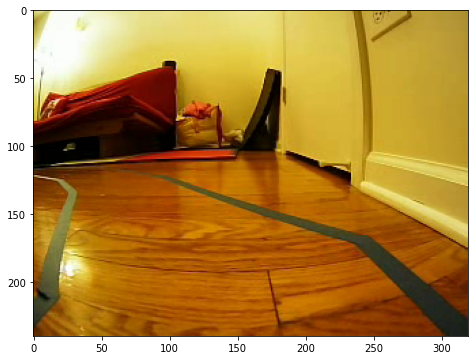

In [16]:
test_sample_index = 0

rgb_image = load_image(image_paths[test_sample_index])
steering_angle = steering_angles[test_sample_index]
print("origin_steering_angle=",steering_angle)
show_image(rgb_image)

### 1> 이미지 줌(확대하기)

In [17]:
def zoom(image,perct=0.3):
    zoom = img_aug.Affine(scale=(1, 1.0+perct))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

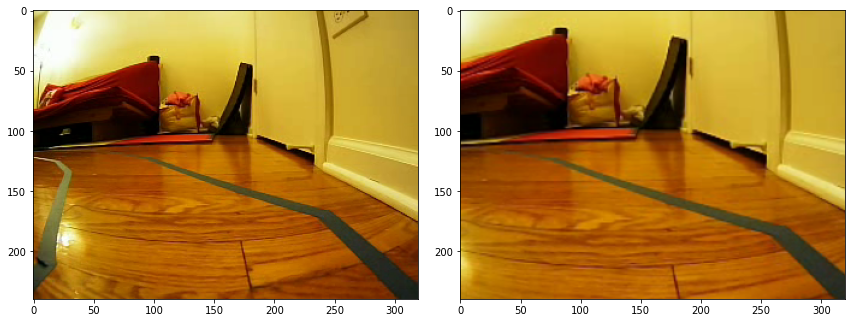

In [18]:
zoomed_image = zoom(rgb_image)
show_compare_images(rgb_image,zoomed_image)

### 2> 뒤집기(flip) : 좌우로 뒤집기

In [19]:
#
# random값(0,1)을 계산하고, 좌우 뒤집을지에 대해서 결정
# 
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        steering_angle = 180 - steering_angle
   
    return image, steering_angle

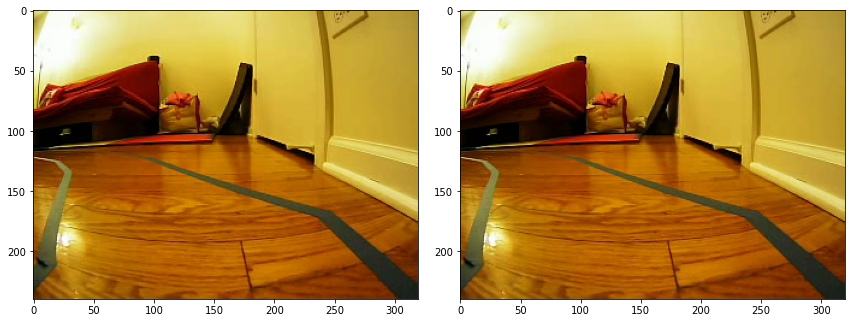

In [21]:
flipped_image,flipped_steering_angle = random_flip(rgb_image,steering_angle)
show_compare_images(rgb_image,flipped_image)

### 3> 패닝(이미지 이동하기)

In [22]:
def pan(image,perct=0.1):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-1*perct, perct), "y": (-1*perct, perct)})
    image = pan.augment_image(image)
    return image

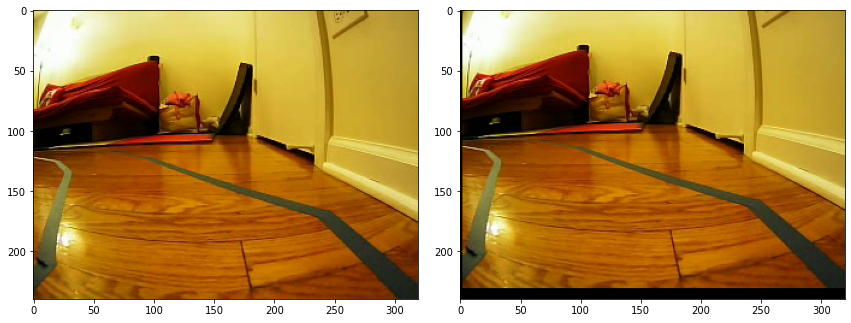

In [23]:
panned_image = pan(rgb_image)
show_compare_images(rgb_image,panned_image)

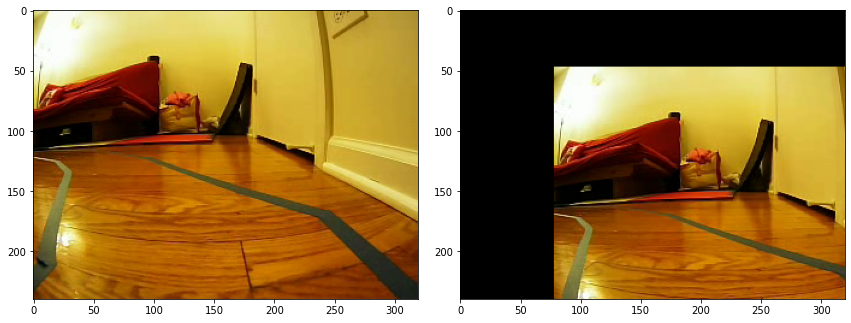

In [24]:
panned_image = pan(rgb_image,perct=0.3)
show_compare_images(rgb_image,panned_image)

### 4> 이미지 밝기 변화시키기

In [25]:
def adjust_brightness(image,perct=0.3):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((1.0-perct, 1.0+perct))
    image = brightness.augment_image(image)
    return image

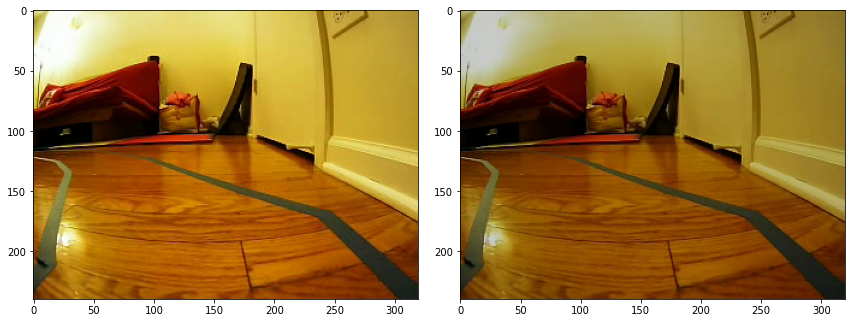

In [26]:
adjusted_brgt_image = adjust_brightness(rgb_image)
show_compare_images(rgb_image,adjusted_brgt_image)

### 5> Blurring(블러링)

In [27]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

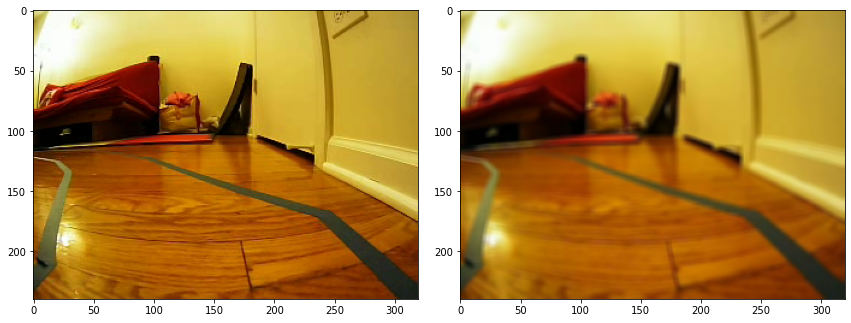

In [28]:
blurred_image = blur(rgb_image)
show_compare_images(rgb_image,blurred_image)

### 6> 여러 변형들을 추가하여 이미지 증강하기(augment)

In [29]:
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
        #print("..pan..")
    if np.random.rand() < 0.5:
        image = zoom(image)
        #print("..zoom..")
    if np.random.rand() < 0.5:
        image = blur(image)
        #print("..blur..")
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
        #print("..adjust_brightness..")

    image, steering_angle = random_flip(image, steering_angle)
    #print("..flipped_angle=>",steering_angle)
    
    return image, steering_angle

origin_steering_angle= 62


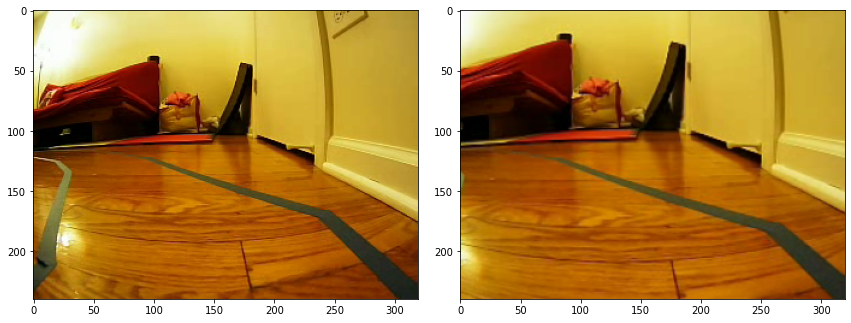

In [30]:
print("origin_steering_angle=",steering_angle)
rand_aug_image, flipped_steering_angle = random_augment(rgb_image,steering_angle)
show_compare_images(rgb_image,rand_aug_image)

## [6] 이미지 전처리하기(preprocessing)
* NVIDIA모델의 입력 크기로 변경

### 1> 이미지 전처의 단계별 수행과정 이해
* 이미지의 크기 변경 (높이를 1/2로 변경)

In [31]:
# 이미지의 rgb 차원의 slice값으로 이미지 크기를 변경
height, _, _ = rgb_image.shape
resized_rgb_image = rgb_image[int(height/2):,:,:] 

In [32]:
rgb_image.shape

(240, 320, 3)

In [33]:
resized_rgb_image.shape

(120, 320, 3)

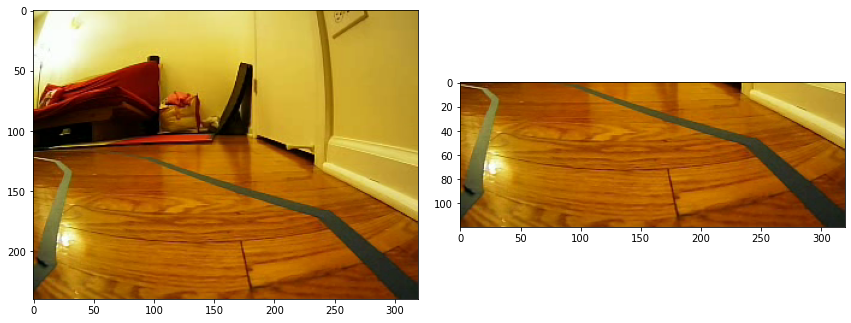

In [34]:
show_compare_images(rgb_image, resized_rgb_image)

### 2> 이미지의 형식변경 (RGB -> YUV)

In [35]:
resized_yuv_image = cv2.cvtColor(resized_rgb_image, cv2.COLOR_RGB2YUV)

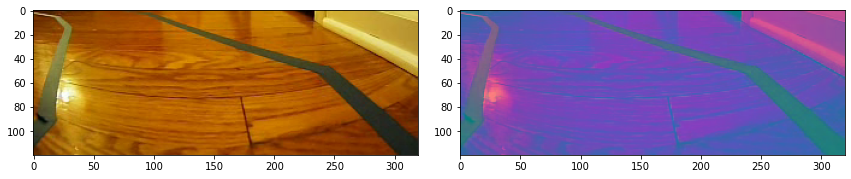

In [36]:
show_compare_images(resized_rgb_image, resized_yuv_image)

### 3> 가우시언블러링 처리(kernel size= 3)

In [37]:
resized_yuv_blurred_image = cv2.GaussianBlur(resized_yuv_image, (3,3), 0)

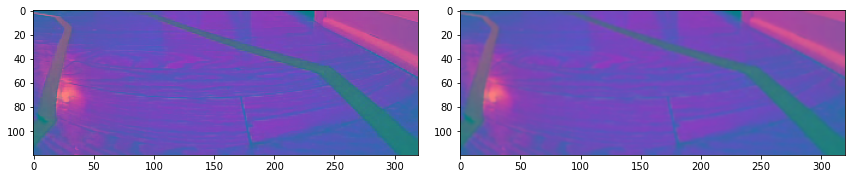

In [38]:
show_compare_images(resized_yuv_image, resized_yuv_blurred_image)

### 4> 이미지 크기 변경 (340x320 -> 66x200)

In [39]:
nvidia_input_image = cv2.resize(resized_yuv_blurred_image, (200,66))

In [40]:
nvidia_input_image.shape

(66, 200, 3)

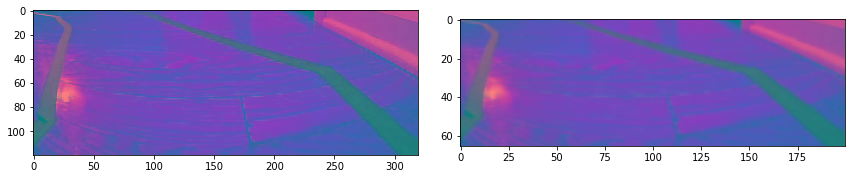

In [41]:
show_compare_images(resized_yuv_image, nvidia_input_image)

### 5> 위의 처리과정의 통합 함수 (img_preprocess)

In [42]:
# 1) 이미지의 포맷을 RGB2YUV로 변경
# 2) GuassianBlur처리를 수행
# 3) 프레임이미지 크기 변경 : 240x320 ->66x200

def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) 
    image = image / 255 
    return image

In [43]:
prep_image = img_preprocess(rgb_image)

In [44]:
prep_image.shape

(66, 200, 3)

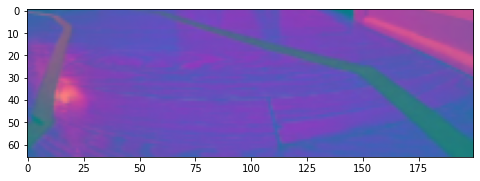

In [45]:
show_image(prep_image)

## [7] NVIDIA 모델 정의하기

### 1> NVIDIA Deep Learning 모델 정의하기

In [46]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

### 2> 모델생성하기 

In [47]:
model = nvidia_model()
print(model.summary())
# check at we will have 252,219 trainable parameters

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

## [8] 학습데이타 생성하기

### 1> 학습데이타 생성을 위한 iterator정의하기
* 학습데이타의 경우, 데이타 증강(augment)를 수행

In [48]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = load_image(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

### 2> 이미지 생성 Iterator 테스팅하기 
* batch_size만큼 제대로 생성하는지 테스팅하기

In [49]:
batch_size = 2
X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, batch_size, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, batch_size, False))

In [50]:
len(X_train_batch)

2

In [51]:
# 학습데이타와 검증데이타의 주행속도 및 이미지예시 (0번째)
y_train_batch[0], y_valid_batch[0]

(74, 61)

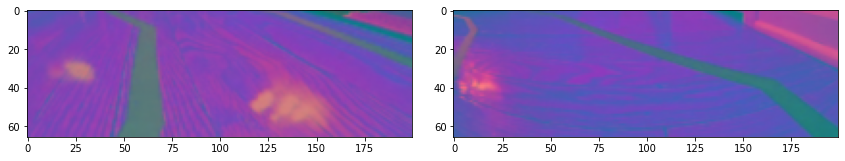

In [52]:
show_compare_images(X_train_batch[0],X_valid_batch[0])

In [53]:
# 학습데이타와 검증데이타의 주행속도 및 이미지예시 (1번째)
y_train_batch[1], y_valid_batch[1]

(109, 85)

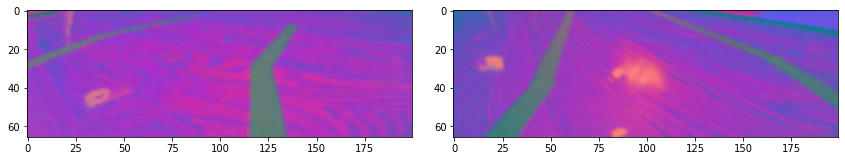

In [54]:
show_compare_images(X_train_batch[1],X_valid_batch[1])

## [9] NVIDIA 주행 모델 학습하기 

### 1> Tensorboard 설정하기

In [55]:
model_output_dir = '/content/DeepPiCar/models/lane_navigation'
! mkdir '/content/DeepPiCar/models/lane_navigation/logs'

In [56]:
# tensorflow의 수행 로그 저장 디렉토리 설정하기
log_dir_root = f'{model_output_dir}/logs/'
log_dir_root

'/content/DeepPiCar/models/lane_navigation/logs/'

In [57]:
# callback함수 정의하기
checkpoint_callback = keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), 
                verbose=1, 
                save_best_only=True)

### 2> NVIDIA주행 학습하기

* batch_size=100으로 기본값 설정
![fit_generator설명](https://api.monosnap.com/file/download?id=L62Mef3nlC4BygocXazCca6StYRMdu)

In [59]:
history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])


Epoch 1/2
300/300 [==============================] - 303s 1s/step - loss: 205.5186 - val_loss: 84.7827

Epoch 00001: val_loss improved from 623.54388 to 84.78268, saving model to /content/DeepPiCar/models/lane_navigation/lane_navigation_check.h5
Epoch 2/2
300/300 [==============================] - 296s 987ms/step - loss: 39.5589 - val_loss: 24.2784

Epoch 00002: val_loss improved from 84.78268 to 24.27842, saving model to /content/DeepPiCar/models/lane_navigation/lane_navigation_check.h5


### 3> 학습모델 저장하기

In [60]:
# epoch를 반복하면서 저장된 모델값은 _check.h5로 저장 
# 최종적인 학습모델의 값을 저장 

model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

## [10] 검증하기(validation)

### 1> 학습 및 검증오류 확인하기(그래프)

In [61]:
history.history

{'loss': [205.51864222208658, 39.55890261332194],
 'val_loss': [84.78267669677734, 24.278423309326172]}

In [62]:
# 학습데이타의 손실/epoch
history.history['loss']

[205.51864222208658, 39.55890261332194]

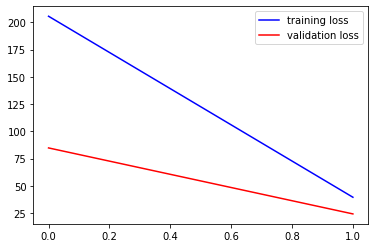

In [63]:
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

### 2> 학습모델 로딩 및 검증결과 출력하기

In [64]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

### 3> 검증결과 출력하기

In [65]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))
y_pred = predict_and_summarize(X_test, y_test)

mse       = 2.7e+01
r_squared = 87.85%



### 4> 검증결과 이미지출력하기 

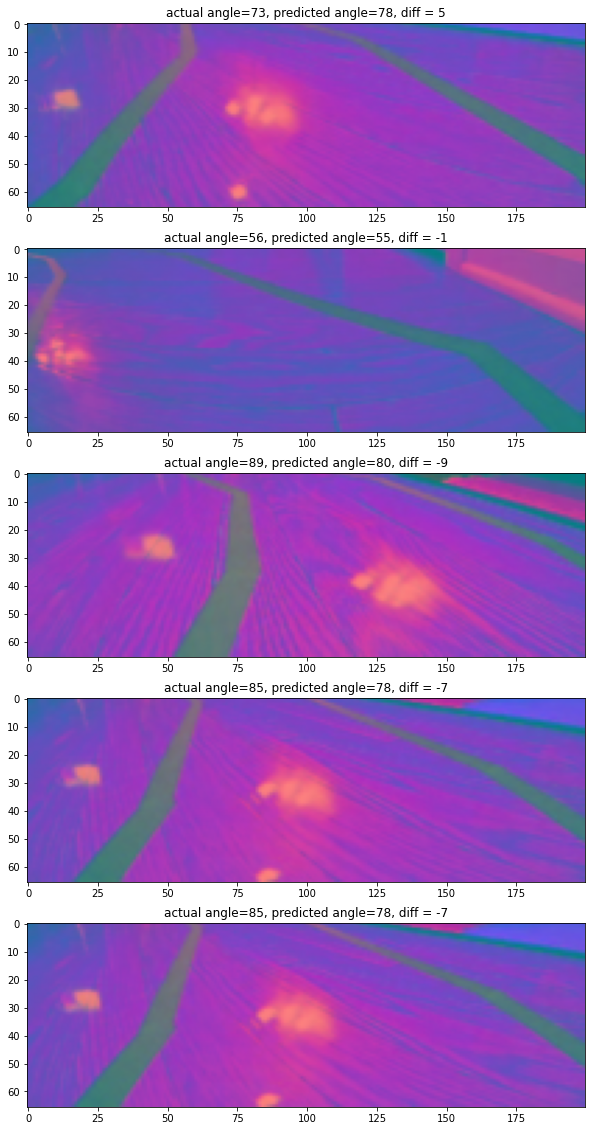

In [66]:
n_tests_show = 5
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")

## [11] 학슴모델 로딩 및 파라미터 확인하기

In [67]:
from tensorflow import keras

model_path = os.path.join(model_output_dir,'lane_navigation_final.h5')
print(model_path)

/content/DeepPiCar/models/lane_navigation/lane_navigation_final.h5


In [68]:
# keras model 로딩하기
loaded_model = keras.models.load_model(model_path)

In [69]:
#dir(loaded_model)

In [70]:
to_json = loaded_model.to_json()
print(to_json)

{"class_name": "Sequential", "config": {"name": "Nvidia_Model", "layers": [{"class_name": "Conv2D", "config": {"name": "conv2d_1", "trainable": true, "batch_input_shape": [null, 66, 200, 3], "dtype": "float32", "filters": 24, "kernel_size": [5, 5], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "elu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Conv2D", "config": {"name": "conv2d_2", "trainable": true, "dtype": "float32", "filters": 36, "kernel_size": [5, 5], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "elu", "use_bias": true, "kernel_

In [71]:
import pprint
import json

In [72]:
pp = pprint.PrettyPrinter()
pp.pprint(json.loads(to_json))

{'backend': 'tensorflow',
 'class_name': 'Sequential',
 'config': {'build_input_shape': [None, 66, 200, 3],
            'layers': [{'class_name': 'Conv2D',
                        'config': {'activation': 'elu',
                                   'activity_regularizer': None,
                                   'batch_input_shape': [None, 66, 200, 3],
                                   'bias_constraint': None,
                                   'bias_initializer': {'class_name': 'Zeros',
                                                        'config': {}},
                                   'bias_regularizer': None,
                                   'data_format': 'channels_last',
                                   'dilation_rate': [1, 1],
                                   'dtype': 'float32',
                                   'filters': 24,
                                   'kernel_constraint': None,
                                   'kernel_initializer': {'class_name': 'VarianceS